# Fate probability analysis

### Introduction

Here, we demonstrate how to perform differential fate probability analysis using [CellRank](https://www.nature.com/articles/s41592-021-01346-6).<br>
In this tutorial, we use our PMCA Jak2 dataset.

### Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from anndata import AnnData
import scvelo as scv
import cellrank as cr
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import rcParams
rcParams['figure.figsize'] = (5, 5)
import random
random.seed(123)
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 
import warnings
warnings.filterwarnings("ignore")

### Loading data

Starting from the raw count to compute the HSC score. The raw count data can be found in the "data" directory ('PMCA_Jak2_raw_count.h5ad').

In [2]:
pmca_raw = sc.read('data/PMCA_Jak2_raw_count.h5ad')

### Computing HSC score

To define the root cell for computing pseudotime, we use a previously developed HSC score
([Wilson, et al.](https://www.sciencedirect.com/science/article/pii/S1934590915001629)). <br>

You can compute the HSC score with our python script as shown below. The script can be found in the "scripts" directory. When you analyze your own data, please change the "params" section within the python script.

In [3]:
!python scripts/hscscore.py

Completed


In [4]:
# Adding HSC score to metadata
hsc_score = pd.read_csv('data/PMCA_Jak2_hsc_scores.csv',index_col=0)
hsc_score.columns = ['HSC_score']
pmca_raw.obs = pd.concat([pmca_raw.obs, hsc_score], axis=1)

### Preprocessing

We compute the fate probabilities for each sample (i.e., each animal) independently. In this tutorial, we use one of our samples to demonstrate the workflow.

In [5]:
adata = pmca_raw[pmca_raw.obs.library=='SLX11516_SIGAC2',:].copy()

In [6]:
# Removing the cells without assigned cell types
adata = adata[(adata.obs['celltype']!='Unassigned'),:]

In [7]:
# Log-normalization
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

In [8]:
# Using only HVGs
hvg = np.genfromtxt('scripts/Dahlin_HVG.txt', dtype=str)
adata = adata[:,hvg]

In [9]:
adata.raw = adata.copy()

In [10]:
sc.pp.scale(adata)

In [11]:
sc.tl.pca(adata, n_comps=50, svd_solver = 'arpack')

In [12]:
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 50)

In [13]:
sc.tl.diffmap(adata)

### Computing diffusion pseudotime

Smoothing the HSC score

In [14]:
adata_hsc = adata[adata.obs['celltype']=='HSCs'].copy()
X_diffmap = adata_hsc.obsm['X_diffmap']

In [15]:
D_sub = euclidean_distances(X_diffmap, X_diffmap)

In [16]:
knn = D_sub
smoothed = []

for i in range(knn.shape[0]):
    tmp = np.array(knn[i])
    ind = np.argpartition(tmp, 10)[:10]
    neighbours = adata_hsc.obs.index[ind]
    
    adata_tmp = adata_hsc[neighbours,:].copy()
    
    array_tmp = np.append(adata_tmp.obs['HSC_score'], adata_hsc.obs['HSC_score'][1])
    knn_mean_tmp = array_tmp.mean()
    smoothed.append(knn_mean_tmp)

In [17]:
adata_hsc.obs['HSC_score_smoothed'] = smoothed

Defining the root cell as the cell with the highest smoothed HSC score

In [18]:
root_idx = adata_hsc.obs['HSC_score_smoothed'].idxmax()
adata.uns['iroot'] = np.flatnonzero(adata.obs.index  == root_idx)[0]

Computing diffusion pseudotime

In [19]:
sc.tl.dpt(adata)

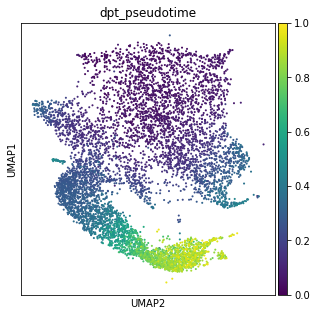

In [20]:
sc.pl.umap(adata, color='dpt_pseudotime',components=['2,1'])

### Identifying terminal states

Terminal cells are determined by identifying the nearest neighbors of the Dahlin's reference terminal cells. Please download our reference atlas ('Dahlin_atlas.h5ad') from the [PMCA web portal](https://gottgens-lab.stemcells.cam.ac.uk/preleukemia_atlas/).<br>
Please also download the processed Jak2 dataset ('PMCA_Jak2.h5ad') as we use the integrated PCA instead of the sample-wise PCA computed above.

In [21]:
dahlin_adata = sc.read('data/Dahlin_atlas.h5ad')
integrated_jak2 = sc.read('data/PMCA_Jak2.h5ad')

In [22]:
dahlin_adata = dahlin_adata[(dahlin_adata.obs['celltype']!='Unassigned'),:].copy()
integrated_jak2 = integrated_jak2[adata.obs.index,:].copy()

In [23]:
dahlin_terminal = pd.read_csv('scripts/Dahlin_terminal_states.csv',index_col=0)
dahlin_adata.obs = pd.concat([dahlin_adata.obs, dahlin_terminal], axis=1)

Identifying nearest neighbors in the common PCA space.

In [24]:
X_pca1 = integrated_jak2.obsm['X_pca']
X_pca2 = dahlin_adata.obsm['X_pca']
D_sub = euclidean_distances(X_pca2, X_pca1)

In [25]:
from collections import Counter
cl_assigned = []
n_neighbours = 10

for i in range(D_sub.shape[0]):
    CellDis = D_sub[i,:]
    CellDis_sorted = np.argpartition(CellDis, n_neighbours)[:n_neighbours]
    max_samples = adata.obs_names[CellDis_sorted]
    cl_assigned.append(max_samples)

In [26]:
def Obs_sublabels(ref_data, proj_data, proj_data_obs, cl_assigned, prefix):
    CT = np.unique(proj_data.obs[proj_data_obs])
    for ct in CT:
        cl_assigned_sub = [cl_assigned[i] for i in np.where(proj_data.obs[proj_data_obs] == ct)[0]]
        cl_flat_sub = [item for sublist in cl_assigned_sub for item in sublist]
        freq1 = Counter(cl_flat_sub)
        freq2 = np.array([0] * ref_data.X.shape[0])
        for k, i in freq1.items():
            if k in ref_data.obs_names:
                idx = np.where(ref_data.obs_names==k)
                freq2[idx] = i
        ref_data.obs[prefix+'_'+ct] = np.log2(freq2+1)

In [27]:
Obs_sublabels(adata, dahlin_adata, 'terminal_states', cl_assigned, 'terminal_projected')

Using the cells with more than one neighboring Dahlin's terminal cell.

In [28]:
ter_cell_Ery = adata.obs.index[(adata.obs['terminal_projected_Ery']>=2) & (adata.obs['celltype']=='Late_Ery')]
ter_cell_Mk = adata.obs.index[(adata.obs['terminal_projected_Mk']>=2) & (adata.obs['celltype']=='Megakry')]
ter_cell_Neu = adata.obs.index[(adata.obs['terminal_projected_Neu']>=2) & (adata.obs['celltype']=='Neu')]
ter_cell_Mo = adata.obs.index[(adata.obs['terminal_projected_Mo_DC']>=2) & (adata.obs['celltype']=='Mo_DC')]
ter_cell_Lym = adata.obs.index[(adata.obs['terminal_projected_Lym']>=2) & (adata.obs['celltype']=='Lym')]
ter_cell_Baso = adata.obs.index[(adata.obs['terminal_projected_Baso']>=2) & (adata.obs['celltype']=='Baso')]
ter_cell_Mast = adata.obs.index[(adata.obs['terminal_projected_Mast']>=2) & (adata.obs['celltype']=='Mast')]

In [29]:
ter_cell_transfer = pd.Series(np.nan, index=adata.obs_names)
ter_cell_transfer[ter_cell_Ery] = 'Ery'
ter_cell_transfer[ter_cell_Mk] = 'Mk'
ter_cell_transfer[ter_cell_Neu] = 'Neu'
ter_cell_transfer[ter_cell_Mo] = 'Mo_DC'
ter_cell_transfer[ter_cell_Lym] = 'Lym'
ter_cell_transfer[ter_cell_Baso] = 'Baso'
ter_cell_transfer[ter_cell_Mast] = 'Mast'

In [30]:
adata.obs['ter_cell_transfer'] = ter_cell_transfer
adata.uns['ter_cell_transfer_colors']=["#1f77b4", "#aa40fc", "#8c564b", "#98df8a", "#b5bd61", "#f9b64e", "#aec7e8"]

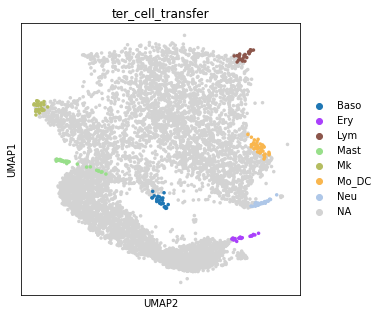

In [31]:
# Terminal cells
sc.pl.umap(adata,color='ter_cell_transfer',s=50,components=['2,1'])

### Computing fate probability

In [32]:
adata.layers["spliced"] = adata.raw.X
adata.layers["unspliced"] = adata.raw.X
scv.pp.moments(adata, n_neighbors=30, n_pcs=50)

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [33]:
# computing transition matrix
pk = cr.tl.kernels.PseudotimeKernel(adata)
pk.compute_transition_matrix(threshold_scheme='soft')

  0%|          | 0/7064 [00:00<?, ?cell/s]

<PseudotimeKernel>

In [34]:
# GPCCA estimator
g_fwd = cr.tl.estimators.GPCCA(pk)

In [35]:
# Manually setting terminal states
g_fwd.set_terminal_states(ter_cell_transfer.astype('category'),cluster_key='celltype')
g_fwd._term_states_colors=["#1f77b4", "#aa40fc", "#8c564b", "#98df8a", "#b5bd61", "#f9b64e", "#aec7e8"]

In [36]:
# Computing absorption probabilities
g_fwd.compute_absorption_probabilities(tol=1e-10)

  0%|          | 0/7 [00:00<?, ?/s]

In [37]:
# Fate probabilities per cell
adata.obsm['to_terminal_states']

Baso,Late_Ery,Lym,Mast,Megakry,Mo_DC,Neu
0.000014,0.999890,0.000001,0.000056,0.000013,0.000006,0.000020
0.000000,0.999999,0.000000,0.000000,0.000000,0.000000,0.000000
0.000048,0.002376,0.000033,0.000044,0.997258,0.000120,0.000122
0.000002,0.999981,0.000000,0.000009,0.000003,0.000001,0.000004
0.000817,0.993892,0.000038,0.003844,0.000408,0.000246,0.000755
0.068557,0.235659,0.100263,0.031953,0.073829,0.234518,0.255220
0.003251,0.291183,0.000971,0.005136,0.691264,0.003562,0.004634
0.007035,0.964481,0.000293,0.015566,0.007632,0.001702,0.003291
0.042960,0.312975,0.052175,0.018222,0.295251,0.129480,0.148937
0.000326,0.997505,0.000022,0.001454,0.000215,0.000113,0.000365


### Visualizing fate probabilities on UMAP

In [38]:
adata.uns['velocity_graph'] = adata.obsp['connectivities']

In [39]:
scv.tl.paga(adata,groups="celltype",end_key="terminal_states_probs",use_time_prior="dpt_pseudotime")

running PAGA using priors: ['dpt_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


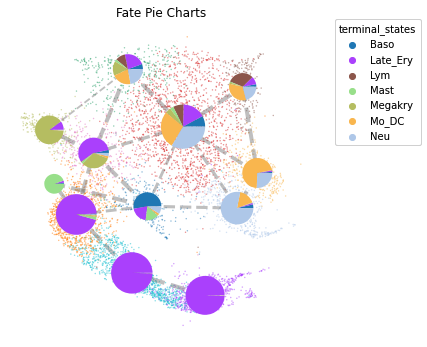

In [40]:
cr.pl.cluster_fates(
    adata,
    mode="paga_pie",
    cluster_key="celltype",
    basis="umap",components='2,1',
    legend_kwargs={"loc": "top right out"},
    legend_loc=None,
    node_size_scale=5,
    edge_width_scale=1,
    max_edge_width=4,
    title="Fate Pie Charts",
    threshold=0.2
)

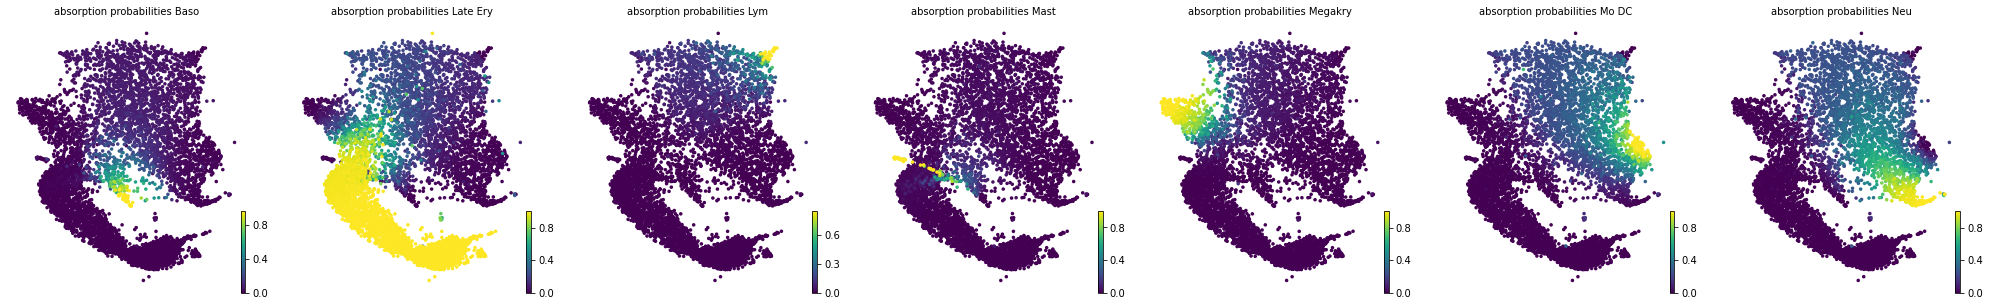

In [41]:
g_fwd.plot_absorption_probabilities(same_plot=False, size=50, basis="umap",components=['2,1'])

### Statistical comparison of mutant and wild-type fate probabilities

After running the above steps with each sample, you can compare two groups of samples for fate differences.<br>
Here we use precomuted fate probabilities for the entire Jak2 dataset (3 mutant and 3 wild-type samples). Precomputed fate probabilities are stored in our processed Jak2 dataset ('PMCA_Jak2.h5ad'), which is available at our web portal.

In [42]:
adata_jak2 = sc.read('data/PMCA_Jak2.h5ad')

In [43]:
# Saving the input files for statistical comparison
# Testing differences for five major lineages
adata_jak2.obs[['fate_prob_Ery', 'fate_prob_Mk', 'fate_prob_Neu', 'fate_prob_Mo', 'fate_prob_Ly']].to_csv('data/Fate_prob_for_LR.csv')
adata_jak2.obs[['dataset','Condition','celltype']].to_csv('data/metadata_for_LR.csv')

Running differential fate probability analysis. When you analyze your own data, please change the "params" section within the R script.

In [44]:
!R --vanilla --slave < scripts/fate_LR.R

Attaching SeuratObject
Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat
Analysis completed


All output files are now saved in the "data" directory.
In our study, lineage fate changes with |median fate probability differences| >5% and BH-adjusted P-values <0.05 were considered significant.